In [2]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Preprocessing Imports
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Import Data

df = pd.read_csv("AmesHousing.csv")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [4]:
# Data Filtering

LOW  = 80_000
HIGH = 400_000

train_mask = (df_train["SalePrice"] >= LOW) & (df_train["SalePrice"] <= HIGH)
housing_train = df_train[train_mask].copy()

test_mask = (df_test["SalePrice"] >= LOW) & (df_test["SalePrice"] <= HIGH)
housing_test = df_test[test_mask].copy()

# Outlier Removal
print("Train size before:", len(df_train), "after:", len(housing_train))
print("Test  size before:", len(df_test),  "after:", len(housing_test))

Train size before: 2344 after: 2233
Test  size before: 586 after: 550


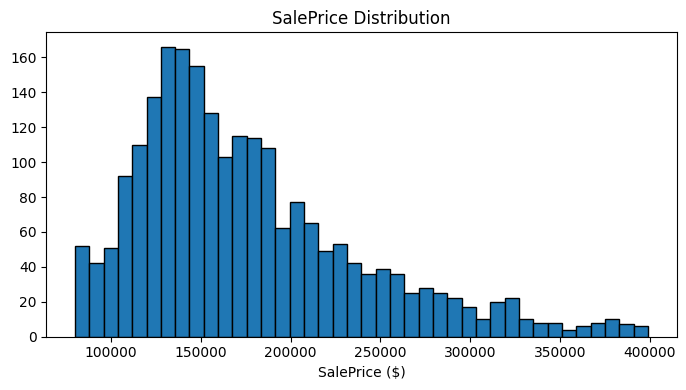

In [5]:
# SalePrice Distribution

plt.figure(figsize=(7,4))
plt.hist(housing_train["SalePrice"], bins=40, edgecolor="black")
plt.xlabel("SalePrice ($)")
plt.title("SalePrice Distribution")
plt.tight_layout()
plt.show()

In [6]:
# Data Preprocessing

# Converting Dtypes
for col in housing_train.select_dtypes(include="object").columns:
    housing_train[col] = housing_train[col].astype("category")

for col in housing_test.select_dtypes(include="object").columns:
    housing_test[col] = housing_test[col].astype("category")

# Numeric / Categorical Columns
train_numeric = housing_train.drop("SalePrice", axis=1).select_dtypes(include="number")
train_cat = housing_train.select_dtypes(include=["category"])

numeric_cols = train_numeric.columns.tolist()
categorical_cols = train_cat.columns.tolist()

numeric_features = numeric_cols
categorical_features = categorical_cols
features = numeric_features + categorical_features
target = "SalePrice"

# Features / Target
X_train = housing_train.drop("SalePrice", axis=1)
y_train = housing_train["SalePrice"]

X_test = housing_test.drop("SalePrice", axis=1)
y_test = housing_test["SalePrice"]

# Column Transformers
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")  
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    remainder="drop",
)

In [7]:
# Baseline (Dummy) Model
dummy_mod = make_pipeline(
        preprocessor,
        DummyRegressor()
)

dummy_mod.fit(X_train, y_train)
dummy_pred = dummy_mod.predict(X_test)
dummy_mape = mean_absolute_percentage_error(y_test, dummy_pred)

In [8]:
# XGBoost Model
param_grid = {
    "xgbregressor__n_estimators": [100, 200, 300],   
    "xgbregressor__max_depth": [2, 3, 4],    
    "xgbregressor__learning_rate": [.05, .08, 0.10, 0.13, 0.15],    
    "xgbregressor__min_child_weight": [1, 2, 3, 5, 10],    
}

pipeline = make_pipeline(
    preprocessor,
    XGBRegressor(random_state=42, n_jobs=-1)
)

model_xg = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_percentage_error",  
    n_jobs=-1,
    verbose=1
)

model_xg.fit(X_train, y_train)

xg2_best = model_xg.best_estimator_

y_pred = xg2_best.predict(X_test)
y_pred_train = xg2_best.predict(X_train)

test_mape = mean_absolute_percentage_error(y_test, y_pred)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)

# MAPE Optimized Model
print("Best params:", model_xg.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best params: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 2, 'xgbregressor__n_estimators': 300}


In [9]:
# XGBoost Prediction Interval

def proportion_within_threshold(y_true, y_pred, threshold=0.20):
    return np.mean((np.abs(y_pred - y_true) / y_true) <= threshold)

improvement = ((dummy_mape - test_mape) / dummy_mape) * 100

print("XGBoost Model (Baseline)")
print("-----------------------------------------")
print("Test  MAPE: " + str(round(100*test_mape, 2)) + "%")
print("Train MAPE: " + str(round(100*train_mape, 2)) + "%")

print("Model Improvement over Dummy:                       " + str(round(improvement, 2)) + "%")
print("-----------------------------------------")

print("Proportion of predictions within 10% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_pred,threshold=.1)), 2)) + "%")
print("Proportion of predictions within 20% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_pred,threshold=.2)), 2)) + "%")
print("Proportion of predictions within 30% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_pred,threshold=.3)), 2)) + "%")

XGBoost Model (Baseline)
-----------------------------------------
Test  MAPE: 6.68%
Train MAPE: 4.64%
Model Improvement over Dummy:                       78.78%
-----------------------------------------
Proportion of predictions within 10% of true value: 78.55%
Proportion of predictions within 20% of true value: 97.27%
Proportion of predictions within 30% of true value: 98.73%


In [10]:
# XGBoost Model (Feature Selection)
param_grid = {
    "xgbregressor__reg_lambda": [0.0, 0.1, 1.0, 3.0, 10.0, 30.0, 100.0],
    "xgbregressor__reg_alpha":  [0.0, 0.01, 0.1, 0.5, 1.0, 3.0, 10.0],
}

pipe = make_pipeline(
    preprocessor,
    XGBRegressor(
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.1,
        min_child_weight=4,
    )
)

model_xg2 = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1,
    verbose=1,
)

model_xg2.fit(X_train, y_train)

xg2_best = model_xg2.best_estimator_
y_xb2_train = xg2_best.predict(X_train)
y_xb2_test  = xg2_best.predict(X_test)

# Best Selection (L1 / L2 Parameters)
print("Best params:", model_xg2.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best params: {'xgbregressor__reg_alpha': 10.0, 'xgbregressor__reg_lambda': 3.0}


In [11]:
# XGBoost (Feature Selection) Proportions
improvement = ((dummy_mape - mean_absolute_percentage_error(y_test,  y_xb2_test)) / dummy_mape) * 100

print("XGBoost Model (Feature Selection)")
print("-----------------------------------------")
print("Test  MAPE: " + str(round(100*mean_absolute_percentage_error(y_test,  y_xb2_test), 2)) + "%")
print("Train MAPE: " + str(round(100*mean_absolute_percentage_error(y_train,  y_xb2_train), 2)) + "%")
print("Model Improvement over baseline (dummy):            " + str(round(improvement, 2)) + "%")
print("-----------------------------------------")
print("Proportion of predictions within 10% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_xb2_test,threshold=.1)), 2)) + "%")
print("Proportion of predictions within 20% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_xb2_test,threshold=.2)), 2)) + "%")
print("Proportion of predictions within 30% of true value: " + str(round(100*(proportion_within_threshold(y_test,y_xb2_test,threshold=.3)), 2)) + "%")

XGBoost Model (Feature Selection)
-----------------------------------------
Test  MAPE: 6.77%
Train MAPE: 2.96%
Model Improvement over baseline (dummy):            78.5%
-----------------------------------------
Proportion of predictions within 10% of true value: 78.36%
Proportion of predictions within 20% of true value: 96.18%
Proportion of predictions within 30% of true value: 98.91%


In [12]:
# MAPE Segmentation

results = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_xb2_test,
})

# Price Division
results["price_band"] = pd.qcut(results["y_true"], 4, labels=["Low-Priced","Mid-Low","Mid-High","High-Priced"])

# True Price Quartiles
qs = results["y_true"].quantile([0.00, 0.25, 0.50, 0.75, 1.00])
q0, q1, q2, q3, q4 = qs.values

band_ranges = {
    "Low-Priced": (q0, q1),
    "Mid-Low": (q1, q2),
    "Mid-High": (q2, q3),
    "High-Priced": (q3, q4),
}

mape = np.abs((results["y_true"] - results["y_pred"]) / results["y_true"])

segment_mape = (
    mape.groupby(results["price_band"], observed=True)  # observed=True = future default
       .mean()
)
for band, m in segment_mape.items():
    lo, hi = band_ranges[band]
    print(
        f"{band} (${lo:,.0f}–${hi:,.0f}): "
        f"MAPE = {m*100:.2f}%"
    )

Low-Priced ($80,000–$132,000): MAPE = 8.10%
Mid-Low ($132,000–$164,500): MAPE = 6.15%
Mid-High ($164,500–$224,750): MAPE = 5.75%
High-Priced ($224,750–$395,039): MAPE = 7.05%


In [13]:
# predict_price()

def predict_price(idx, model=xg2_best, X=X_test, y=y_test, band=0.10):

    # 1. Get the row as a DataFrame (shape (1, n_features))
    x_row = X.iloc[[idx]]
    true_price = y.iloc[idx]

    # 2. Predict
    pred_price = model.predict(x_row)[0]

    # 3. Compute band
    lower = pred_price * (1 - band)
    upper = pred_price * (1 + band)

    print(f"House index: {idx}")
    print(f"Predicted price:      ${pred_price:,.0f}")
    print(f"Predicted ±{int(band*100)}% range:  "
          f"${lower:,.0f}  to  ${upper:,.0f}")
    print(f"True sale price:      ${true_price:,.0f}")


In [14]:
# Example

predict_price(50) 

House index: 50
Predicted price:      $137,077
Predicted ±10% range:  $123,369  to  $150,785
True sale price:      $134,500


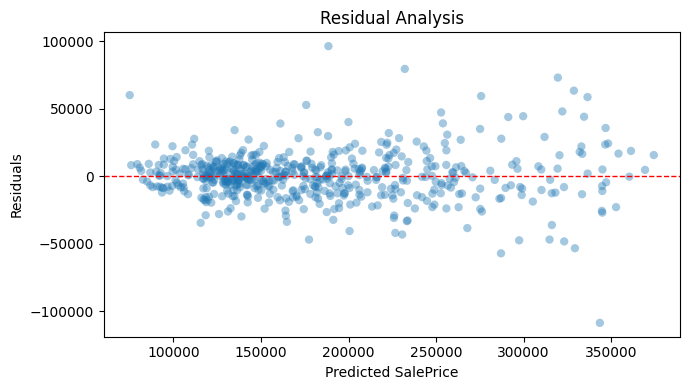

In [15]:
# Residual Analysis

residuals = y_test - y_xb2_test
plt.figure(figsize=(7,4))
plt.scatter(y_xb2_test, residuals, alpha=0.4, edgecolor="none")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.tight_layout()
plt.savefig('residual.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# The Residual Analysis shows that error can be significantly reduced if more training data is used. 
# For houses ~100k -> 200k, lots of data was available, so the model consistently minimized error opposed to the higher ranges. 